In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion

In [4]:
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='03:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=8)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 03:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.82:37872 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.82:37872,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [10]:
import cmocean
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'}, #originally mol/m^3
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [8]:
import glob
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2/" + x

spinup_datafiles = sorted(glob.glob(datadir("CM4Xp125*spinup*")))
historical_datafiles = sorted(glob.glob(datadir("CM4Xp125*historical*")))
ssp585_datafiles = sorted(glob.glob(datadir("CM4Xp125_ssp585*")))
picontrol_datafiles = sorted(glob.glob(datadir("CM4Xp125*piControl*")))
picontrol_datafiles = sorted(list(set(picontrol_datafiles) - set(spinup_datafiles)))

expt_datafiles = {"forced": historical_datafiles + ssp585_datafiles, 
                  "control": picontrol_datafiles}

In [9]:
def zonal_average(ds):
    weights = (ds.thkcello * ds.areacello)
    weights = weights.where(weights > 0)

    ds_nothk = ds.drop_vars("thkcello")
    ds_za = (ds_nothk * weights).sum("xh") / weights.sum("xh")
    ds_za["volume"] = weights.sum("xh")
    
    return ds_za

In [ ]:
for key in expt_datafiles.keys():
    datafiles = expt_datafiles[key]
    ds_zas = []
    for (t, file) in enumerate(datafiles): 
        print(key, ":", file)
        ds = xr.open_mfdataset(
            file,
            data_vars="minimal",
            coords="minimal",
            compat="override",
            parallel=True,
            engine="zarr")
            
        ds["Z"] = approximate_z_on_boundaries(ds, dim = "sigma2")
        
        ds["density"] = ds.sigma2_l * xr.where(ds.thkcello.fillna(0.0) > 0.0, 1, 0) 
        ds["density"] = ds["density"].where(ds["density"] > 0)
        ds["density"].attrs["cell_methods"] = ds["thetao"].attrs["cell_methods"]

        ds = ds.chunk({"sigma2_l":-1, "sigma2_i":-1, "time":1})
        grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

        # dz = 20
        # z_i = np.arange(-6500, 200 + 0.1, dz)
        z_i_1 = np.arange(-6320, -5000 + 0.1, 20)
        z_i_2 = np.arange(z_i_1[-1], 300 + 0.1, 100)
        z_i = np.unique(np.concatenate([z_i_1, z_i_2]))
        z_l = (z_i[1:] + z_i[0:-1]) / 2
        ds = ds.assign_coords({"Z_l": z_l, "Z_i":z_i})
        
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            warnings.simplefilter(action='ignore', category=UserWarning)
            ds_remap = remap_vertical_coord_custom("Z", ds, grid, ds["Z"]) 
            
        ds_za = zonal_average(ds_remap).compute()

        ds_zas += [1 * ds_za]

    ds_za_ts = xr.concat(ds_zas, dim = "time").sortby("time")
    ds_za_ts["geolat"] = ds.geolat.mean("xh").compute()    
    
    savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
    
    savename = savedir + f"Glob_Zonal_Avg_Tracer_{key}.nc"
    print(f"Saving {key} to", ": ", savename)
    ds_za_ts.to_netcdf(savename)

forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2/CM4Xp125_historical_tracers_sigma2_1850-1854.zarr


In [11]:
ds_forced = xr.open_dataset(datadir("../Glob_Zonal_Avg_Tracer_forced.nc"))
ds_ctrl = xr.open_dataset(datadir("../Glob_Zonal_Avg_Tracer_control.nc"))
ds_ctrl.coords["time"] = ds_forced.time.values

Text(0.5, 1.0, 'Forced')

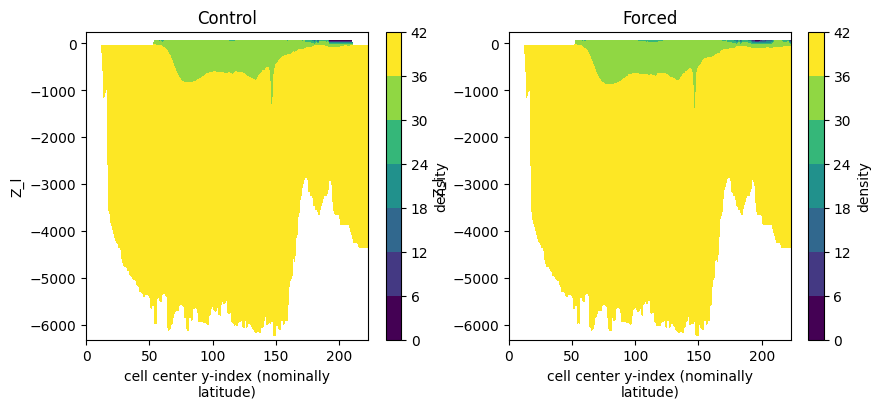

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True)
ds_ctrl.mean("time").density.T.plot.contourf(ax = ax[0])
ax[0].set_title("Control")
ds_forced.mean("time").density.T.plot.contourf(ax = ax[1])
ax[1].set_title("Forced")

Text(0.5, 1.0, 'Forced')

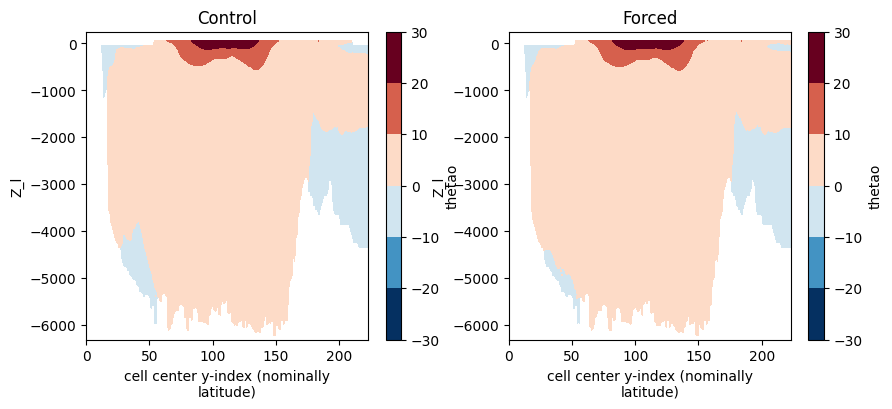

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True)
ds_ctrl.mean("time").thetao.T.plot.contourf(ax = ax[0])
ax[0].set_title("Control")
ds_forced.mean("time").thetao.T.plot.contourf(ax = ax[1])
ax[1].set_title("Forced")

Text(0.5, 1.0, 'Forced')

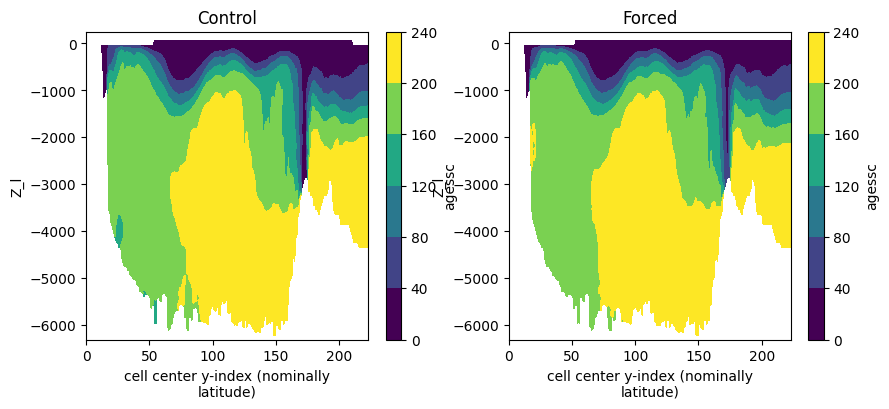

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex = True)
ds_ctrl.mean("time").agessc.T.plot.contourf(ax = ax[0])
ax[0].set_title("Control")
ds_forced.mean("time").agessc.T.plot.contourf(ax = ax[1])
ax[1].set_title("Forced")